In [6]:
!pip install ipdb
import ipdb

Loading image and ground truth mask...
Generating predictions from all models...
  Processing BCE model...
    IoU: 0.6243
  Processing IoU model...
    IoU: 0.5921
  Processing Progressive model...
    IoU: 0.6475
Creating visualization...


/tmp/ipython-input-2809456391.py:434: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.96])



Figure saved to: /content/drive/MyDrive/BBIoULoss_Updated_V7/BBIoULoss_Updated_V5/figures/panel_a_comparison.png


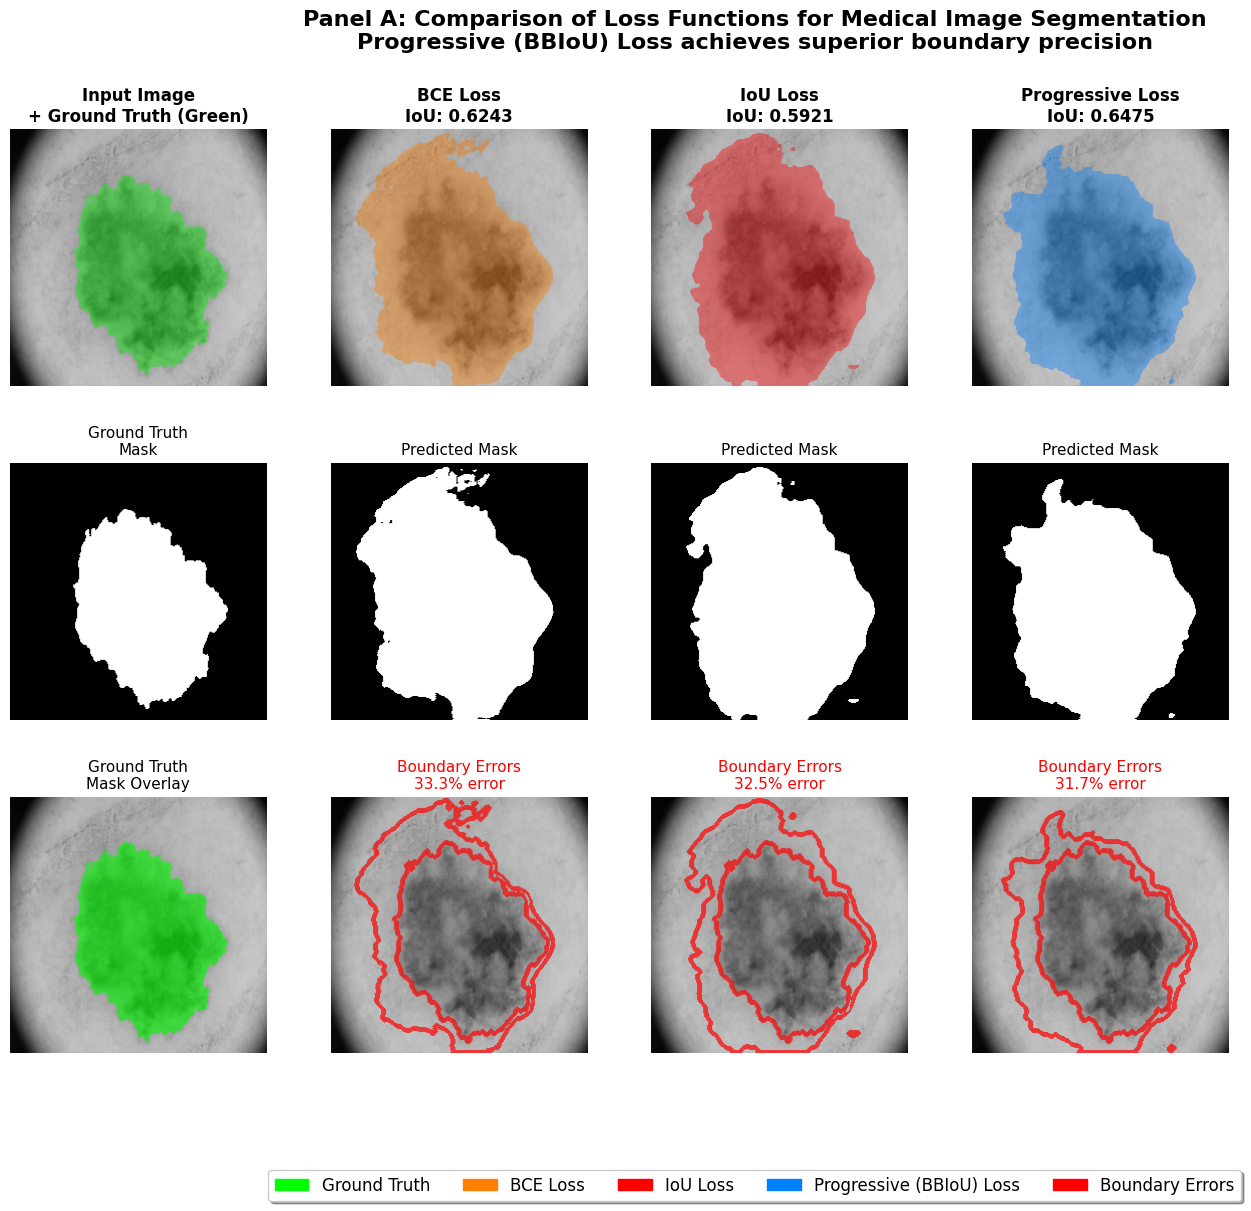


SUMMARY STATISTICS
BCE          | IoU: 0.6243 | Boundary Error: 33.33%
IoU          | IoU: 0.5921 | Boundary Error: 32.50%
Progressive  | IoU: 0.6475 | Boundary Error: 31.68%

✓ Panel A comparison figure generated successfully!


"\nUSAGE INSTRUCTIONS:\n\n1. PREREQUISITES:\n   - Trained models saved as .pth files\n   - Test images and masks in PNG format\n   - Required packages: torch, cv2, numpy, matplotlib\n\n2. CONFIGURATION:\n   Update these variables at the top of the script:\n   - MODEL_PATHS: Dictionary with paths to your 4 trained models\n   - TEST_IMAGE_PATH: Path to a representative test image\n   - TEST_MASK_PATH: Path to corresponding ground truth mask\n   - OUTPUT_PATH: Where to save the generated figure\n\n3. RUNNING THE SCRIPT:\n   python panel_a_comparison.py\n\n4. OUTPUT:\n   - High-resolution figure (300 DPI) saved to OUTPUT_PATH\n   - Console output showing IoU scores and boundary errors\n   - Visual comparison across all loss functions\n\n5. CUSTOMIZATION:\n   - Adjust figure size: Change `figsize=(20, 12)` in line 337\n   - Modify colors: Edit COLORS dictionary in line 356\n   - Change boundary thickness: Adjust `thickness` parameter in line 262\n   - Adjust overlay transparency: Modify `al

In [11]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
import torch.nn.functional as F

# =============================================================================
# CONFIGURATION
# =============================================================================

# Paths to your trained models (update these paths based on your setup)
MODEL_PATHS = {
    'BCE': '/content/drive/MyDrive/BBIoULoss_Updated_V7/BBIoULoss_Updated_V5/checkpoints/UNet_BCEWithLogitsLoss_augmented.pth',
    'IoU': '/content/drive/MyDrive/BBIoULoss_Updated_V7/BBIoULoss_Updated_V5/checkpoints/UNet_IoULoss_augmented.pth',
    #'BiIoU': '/path/to/UNet_BiouLoss_augmented.pth',
    'Progressive': '/content/drive/MyDrive/BBIoULoss_Updated_V7/BBIoULoss_Updated_V5/checkpoints/UNet_Progressive_augmented.pth'
}

# Path to test image and ground truth mask
TEST_IMAGE_PATH = '/content/drive/MyDrive/BBIoULoss_Updated_V7/BBIoULoss_Updated_V5/kvasir-seg-main/data/Skin_Cancer/Train/images/ISIC_0000002.jpg'
TEST_MASK_PATH = '/content/drive/MyDrive/BBIoULoss_Updated_V7/BBIoULoss_Updated_V5/kvasir-seg-main/data/Skin_Cancer/Train/masks/ISIC_0000002.jpg'

# Output path for the generated figure
OUTPUT_PATH = '/content/drive/MyDrive/BBIoULoss_Updated_V7/BBIoULoss_Updated_V5/figures/panel_a_comparison.png'

# Device configuration
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# =============================================================================
# HELPER FUNCTIONS
# =============================================================================

def load_image(image_path, grayscale=True):
    """
    Load an image from disk

    Args:
        image_path: Path to the image file
        grayscale: If True, convert to grayscale

    Returns:
        numpy array of the image
    """
    if grayscale:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    else:
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def preprocess_image(image, target_size=(256, 256)):
    """
    Preprocess image for model input

    Args:
        image: Input image as numpy array
        target_size: Tuple of (height, width) for resizing

    Returns:
        Preprocessed image tensor ready for model input
    """
    # Resize image
    img = cv2.resize(image, target_size)

    # Normalize to [0, 1]
    img = img.astype(np.float32) / 255.0

    # Convert to tensor and add batch + channel dimensions
    img_tensor = torch.from_numpy(img).unsqueeze(0).unsqueeze(0)

    return img_tensor


def load_model(model_path, model_architecture='UNet'):
    """
    Load a trained model from checkpoint

    Args:
        model_path: Path to the model checkpoint (.pth file)
        model_architecture: Architecture name (default: 'UNet')

    Returns:
        Loaded model in evaluation mode
    """
    import sys
    sys.path.append('/content/drive/MyDrive/BBIoULoss_Updated_V7/BBIoULoss_Updated_V5/kvasir-seg-main')

    from models.unet import UNet  # Import your UNet model

    # Initialize model
    model = UNet(channel_in=1, channel_out=1)

    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=DEVICE)
    model.load_state_dict(checkpoint['net'])

    # Set to evaluation mode
    model.eval()
    model.to(DEVICE)

    return model


def predict_mask(model, image_tensor):
    """
    Generate prediction mask from model

    Args:
        model: Trained segmentation model
        image_tensor: Preprocessed image tensor

    Returns:
        Binary prediction mask as numpy array
    """
    with torch.no_grad():
        image_tensor = image_tensor.to(DEVICE)

        # Get model prediction (logits)
        output = model(image_tensor)

        # Apply sigmoid to get probabilities
        prob = torch.sigmoid(output)

        # Threshold at 0.5 to get binary mask
        pred_mask = (prob > 0.5).float()

        # Convert to numpy and remove batch/channel dimensions
        pred_mask = pred_mask.squeeze().cpu().numpy()

    return pred_mask


def compute_boundary_error(pred_mask, gt_mask, thickness=3):
    """
    Compute boundary error regions for visualization

    Args:
        pred_mask: Predicted binary mask
        gt_mask: Ground truth binary mask
        thickness: Thickness of boundary region to consider

    Returns:
        error_mask: Binary mask showing boundary errors (FP and FN at boundaries)
    """
    # Convert to uint8 for OpenCV operations
    pred_uint8 = (pred_mask * 255).astype(np.uint8)
    gt_uint8 = (gt_mask * 255).astype(np.uint8)

    # Find contours (boundaries)
    pred_contours, _ = cv2.findContours(pred_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    gt_contours, _ = cv2.findContours(gt_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # Create boundary masks with specified thickness
    pred_boundary = np.zeros_like(pred_mask, dtype=np.uint8)
    gt_boundary = np.zeros_like(gt_mask, dtype=np.uint8)

    cv2.drawContours(pred_boundary, pred_contours, -1, 1, thickness)
    cv2.drawContours(gt_boundary, gt_contours, -1, 1, thickness)

    # Compute boundary errors
    # False Positives: predicted boundary but no GT boundary
    # False Negatives: GT boundary but no predicted boundary
    boundary_fp = (pred_boundary == 1) & (gt_boundary == 0)
    boundary_fn = (gt_boundary == 1) & (pred_boundary == 0)

    error_mask = boundary_fp | boundary_fn

    return error_mask.astype(np.float32)


def create_overlay(image, mask, color, alpha=0.4):
    """
    Create an overlay of mask on image with specified color

    Args:
        image: Grayscale image (2D array)
        mask: Binary mask (2D array)
        color: RGB color tuple (values 0-1)
        alpha: Transparency of overlay

    Returns:
        RGB image with colored overlay
    """
    # Convert grayscale to RGB
    if len(image.shape) == 2:
        img_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    else:
        img_rgb = image.copy()

    # Normalize image to [0, 1]
    img_rgb = img_rgb.astype(np.float32) / 255.0

    # Create colored overlay
    overlay = img_rgb.copy()
    for c in range(3):
        overlay[:, :, c] = np.where(mask > 0, color[c], img_rgb[:, :, c])

    # Blend with original image
    result = cv2.addWeighted(img_rgb, 1 - alpha, overlay, alpha, 0)

    return result


def compute_iou(pred_mask, gt_mask):
    """
    Compute Intersection over Union (IoU) metric

    Args:
        pred_mask: Predicted binary mask
        gt_mask: Ground truth binary mask

    Returns:
        IoU score (float between 0 and 1)
    """
    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()

    if union == 0:
        return 1.0 if intersection == 0 else 0.0

    iou = intersection / union
    return iou


# =============================================================================
# MAIN VISUALIZATION FUNCTION
# =============================================================================

def create_panel_a_comparison(image_path, mask_path, model_paths, output_path):
    """
    Create Panel A: Comprehensive comparison of loss functions

    This function generates a multi-panel figure showing:
    - Original image with ground truth
    - Predictions from each loss function
    - Boundary error visualization
    - IoU scores for quantitative comparison

    Args:
        image_path: Path to test image
        mask_path: Path to ground truth mask
        model_paths: Dictionary of model paths for each loss function
        output_path: Path to save the output figure
    """

    # =========================================================================
    # STEP 1: Load and preprocess data
    # =========================================================================
    print("Loading image and ground truth mask...")

    # Load original image (raw, for initial processing)
    original_img_raw = load_image(image_path, grayscale=True)

    # Load ground truth mask (raw)
    gt_mask_raw = load_image(mask_path, grayscale=True)
    gt_mask_raw = (gt_mask_raw > 127).astype(np.float32)  # Binarize

    # Preprocess original image for model input. This resizes to 256x256.
    img_tensor = preprocess_image(original_img_raw)

    # For display and comparison, ensure all images and masks are 256x256.
    # The model's prediction will be 256x256.
    original_img_display = cv2.resize(original_img_raw, (256, 256), interpolation=cv2.INTER_LINEAR)
    gt_mask_for_comparison = cv2.resize(gt_mask_raw, (256, 256), interpolation=cv2.INTER_NEAREST)

    # =========================================================================
    # STEP 2: Generate predictions from all models
    # =========================================================================
    print("Generating predictions from all models...")

    predictions = {}
    iou_scores = {}
    boundary_errors = {}

    loss_names = ['BCE', 'IoU', 'Progressive']

    for loss_name in loss_names:
        if loss_name in model_paths and os.path.exists(model_paths[loss_name]):
            print(f"  Processing {loss_name} model...")

            # Load model
            model = load_model(model_paths[loss_name])

            # Generate prediction (will be 256x256)
            pred_mask = predict_mask(model, img_tensor)
            predictions[loss_name] = pred_mask

            # Compute IoU score using the resized ground truth mask for comparison
            iou = compute_iou(pred_mask, gt_mask_for_comparison)
            iou_scores[loss_name] = iou

            # Compute boundary errors using the resized ground truth mask for comparison
            error_mask = compute_boundary_error(pred_mask, gt_mask_for_comparison)
            boundary_errors[loss_name] = error_mask

            print(f"    IoU: {iou:.4f}")
        else:
            print(f"  Warning: Model path for {loss_name} not found!")

    # =========================================================================
    # STEP 3: Create the visualization figure
    # =========================================================================
    print("Creating visualization...")

    # Define figure layout using GridSpec
    # Layout: 3 rows x 5 columns
    # Row 1: Input | BCE | IoU | BiIoU | Progressive
    # Row 2: GT Overlay on each
    # Row 3: Boundary errors

    fig = plt.figure(figsize=(20, 12))
    gs = GridSpec(3, 5, figure=fig, hspace=0.3, wspace=0.2)

    # Color scheme for overlays
    COLORS = {
        'GT': (0, 1, 0),        # Green for ground truth
        'BCE': (1, 0.5, 0),     # Orange for BCE
        'IoU': (1, 0, 0),       # Red for IoU
        #'BiIoU': (0.5, 0, 1),   # Purple for BiIoU
        'Progressive': (0, 0.5, 1)  # Blue for Progressive
    }

    # -------------------------------------------------------------------------
    # Row 1: Original Image and Prediction Overlays
    # -------------------------------------------------------------------------

    # Column 0: Original Image with Ground Truth
    ax_input = fig.add_subplot(gs[0, 0])
    gt_overlay = create_overlay(original_img_display, gt_mask_for_comparison, COLORS['GT'], alpha=0.4)
    ax_input.imshow(gt_overlay)
    ax_input.set_title('Input Image\n+ Ground Truth (Green)', fontsize=12, fontweight='bold')
    ax_input.axis('off')

    # Columns 1-4: Predictions from each loss function
    for idx, loss_name in enumerate(loss_names, start=1):
        ax = fig.add_subplot(gs[0, idx])

        if loss_name in predictions:
            pred_overlay = create_overlay(original_img_display, predictions[loss_name],
                                         COLORS[loss_name], alpha=0.4)
            ax.imshow(pred_overlay)
            title = f'{loss_name} Loss\nIoU: {iou_scores[loss_name]:.4f}'
        else:
            # Show blank if model not available, using the display sized original image
            ax.imshow(original_img_display, cmap='gray')
            title = f'{loss_name} Loss\n(Not Available)'

        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.axis('off')

    # -------------------------------------------------------------------------
    # Row 2: Ground Truth + Prediction Comparison
    # -------------------------------------------------------------------------

    # Column 0: Ground Truth Only
    ax_gt = fig.add_subplot(gs[1, 0])
    ax_gt.imshow(gt_mask_for_comparison, cmap='gray')
    ax_gt.set_title('Ground Truth\nMask', fontsize=11)
    ax_gt.axis('off')

    # Columns 1-4: Prediction masks
    for idx, loss_name in enumerate(loss_names, start=1):
        ax = fig.add_subplot(gs[1, idx])

        if loss_name in predictions:
            ax.imshow(predictions[loss_name], cmap='gray')
            ax.set_title(f'Predicted Mask', fontsize=11)
        else:
            ax.imshow(np.zeros_like(gt_mask_for_comparison), cmap='gray')
            ax.set_title('N/A', fontsize=11)

        ax.axis('off')

    # -------------------------------------------------------------------------
    # Row 3: Boundary Error Visualization
    # -------------------------------------------------------------------------

    # Column 0: Ground Truth Boundary (displayed as an overlay of the mask)
    ax_gt_boundary = fig.add_subplot(gs[2, 0])
    ax_gt_boundary.imshow(create_overlay(original_img_display, gt_mask_for_comparison > 0, COLORS['GT'], alpha=0.6))
    ax_gt_boundary.set_title('Ground Truth\nMask Overlay', fontsize=11) # Changed title for clarity
    ax_gt_boundary.axis('off')

    # Columns 1-4: Boundary errors (FP=Red, FN=Yellow)
    for idx, loss_name in enumerate(loss_names, start=1):
        ax = fig.add_subplot(gs[2, idx])

        if loss_name in boundary_errors:
            # Create error visualization with overlay on the resized original image
            error_overlay = create_overlay(original_img_display, boundary_errors[loss_name],
                                          (1, 0, 0), alpha=0.7)  # Red for errors
            ax.imshow(error_overlay)

            # Calculate boundary error percentage using the resized GT mask for sum
            error_pct = (boundary_errors[loss_name].sum() / gt_mask_for_comparison.sum() * 100) if gt_mask_for_comparison.sum() > 0 else 0
            ax.set_title(f'Boundary Errors\n{error_pct:.1f}% error', fontsize=11, color='red')
        else:
            ax.imshow(original_img_display, cmap='gray')
            ax.set_title('N/A', fontsize=11)

        ax.axis('off')

    # =========================================================================
    # STEP 4: Add overall title and legend
    # =========================================================================

    # Main title
    fig.suptitle('Comparison of Loss Functions for Medical Image Segmentation\n' +
                 'Progressive (BBIoU) Loss achieves superior boundary precision',
                 fontsize=16, fontweight='bold', y=0.98)

    # Create legend
    legend_elements = [
        mpatches.Patch(color=COLORS['GT'], label='Ground Truth'),
        mpatches.Patch(color=COLORS['BCE'], label='BCE Loss'),
        mpatches.Patch(color=COLORS['IoU'], label='IoU Loss'),
        #mpatches.Patch(color=COLORS['BiIoU'], label='BiIoU Loss'),
        mpatches.Patch(color=COLORS['Progressive'], label='Progressive (BBIoU) Loss'),
        mpatches.Patch(color=(1, 0, 0), label='Boundary Errors')
    ]

    fig.legend(handles=legend_elements, loc='lower center', ncol=6,
              fontsize=12, frameon=True, fancybox=True, shadow=True,
              bbox_to_anchor=(0.5, -0.02))

    # =========================================================================
    # STEP 5: Save the figure
    # =========================================================================

    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"\nFigure saved to: {output_path}")

    # Also display if running in notebook
    plt.show()

    # =========================================================================
    # STEP 6: Print summary statistics
    # =========================================================================

    print("\n" + "="*60)
    print("SUMMARY STATISTICS")
    print("="*60)

    for loss_name in loss_names:
        if loss_name in iou_scores:
            # Ensure the sum is calculated with the resized GT mask
            error_pct = (boundary_errors[loss_name].sum() / gt_mask_for_comparison.sum() * 100) if gt_mask_for_comparison.sum() > 0 else 0
            print(f"{loss_name:12s} | IoU: {iou_scores[loss_name]:.4f} | Boundary Error: {error_pct:.2f}%")

    print("="*60)


# =============================================================================
# EXECUTION
# =============================================================================

if __name__ == "__main__":
    """
    Main execution block

    To use this script:
    1. Update MODEL_PATHS with your trained model checkpoint paths
    2. Update TEST_IMAGE_PATH and TEST_MASK_PATH with your test data
    3. Update OUTPUT_PATH for where to save the figure
    4. Run the script
    """

    # Verify paths exist
    if not os.path.exists(TEST_IMAGE_PATH):
        print(f"Error: Test image not found at {TEST_IMAGE_PATH}")
        print("Please update TEST_IMAGE_PATH with a valid image path")
    elif not os.path.exists(TEST_MASK_PATH):
        print(f"Error: Test mask not found at {TEST_MASK_PATH}")
        print("Please update TEST_MASK_PATH with a valid mask path")
    else:
        # Create output directory if it doesn't exist
        os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

        # Generate the comparison figure
        create_panel_a_comparison(
            image_path=TEST_IMAGE_PATH,
            mask_path=TEST_MASK_PATH,
            model_paths=MODEL_PATHS,
            output_path=OUTPUT_PATH
        )

        print("\n✓ Panel A comparison figure generated successfully!")


# =============================================================================
# USAGE NOTES
# =============================================================================
"""
USAGE INSTRUCTIONS:

1. PREREQUISITES:
   - Trained models saved as .pth files
   - Test images and masks in PNG format
   - Required packages: torch, cv2, numpy, matplotlib

2. CONFIGURATION:
   Update these variables at the top of the script:
   - MODEL_PATHS: Dictionary with paths to your 4 trained models
   - TEST_IMAGE_PATH: Path to a representative test image
   - TEST_MASK_PATH: Path to corresponding ground truth mask
   - OUTPUT_PATH: Where to save the generated figure

3. RUNNING THE SCRIPT:
   python panel_a_comparison.py

4. OUTPUT:
   - High-resolution figure (300 DPI) saved to OUTPUT_PATH
   - Console output showing IoU scores and boundary errors
   - Visual comparison across all loss functions

5. CUSTOMIZATION:
   - Adjust figure size: Change `figsize=(20, 12)` in line 337
   - Modify colors: Edit COLORS dictionary in line 356
   - Change boundary thickness: Adjust `thickness` parameter in line 262
   - Adjust overlay transparency: Modify `alpha` parameter in create_overlay calls

6. TROUBLESHOOTING:
   - If models don't load: Check model architecture matches UNet definition
   - If image sizes differ: Script automatically handles resizing
   - If colors look off: Ensure images are grayscale and masks are binary
"""


✅ Diagram saved successfully to: biou_components_diagram.png


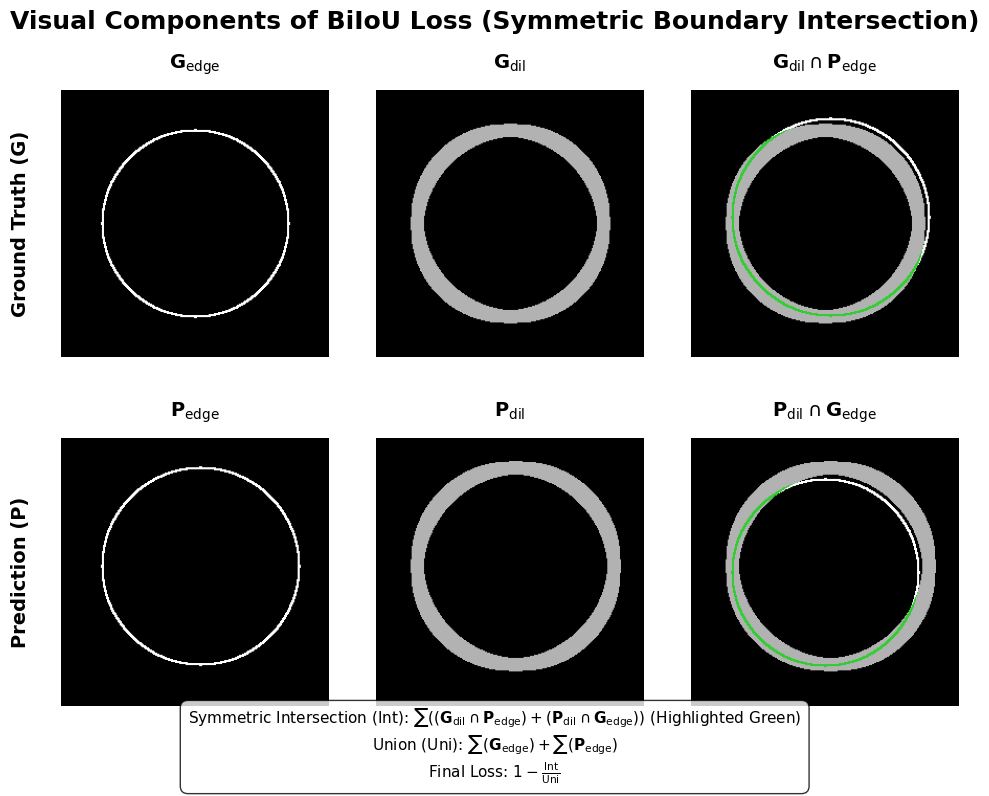

In [13]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

# =============================================================================
# CONFIGURATION & PARAMETERS
# =============================================================================

DEVICE = 'cpu'
IMG_SIZE = 256
DILATION_RATIO = 0.04
EDGE_THRESHOLD_PCT = 0.05
EPS = 1e-6

COLORS = {
    'EDGE': (1.0, 1.0, 1.0),
    'DILATION': (0.7, 0.7, 0.7),
    'INTERSECTION': (0.2, 0.8, 0.2),
}

SOBEL_X = torch.tensor([
    [1, 0, -1], [2, 0, -2], [1, 0, -1]
], dtype=torch.float32).unsqueeze(0).unsqueeze(0)

SOBEL_Y = torch.tensor([
    [1, 2, 1], [0, 0, 0], [-1, -2, -1]
], dtype=torch.float32).unsqueeze(0).unsqueeze(0)

# =============================================================================
# CORE LOSS LOGIC FUNCTIONS
# =============================================================================

def generate_sample_masks(size=IMG_SIZE):
    gt = np.zeros((size, size), dtype=np.uint8)
    cv2.circle(gt, (size//2, size//2), int(size*0.35), 255, -1)

    pred = np.zeros((size, size), dtype=np.uint8)
    cv2.circle(pred, (int(size*0.52), int(size*0.48)), int(size*0.37), 255, -1)

    gt_tensor = torch.from_numpy(gt).float().unsqueeze(0).unsqueeze(0) / 255.0
    pred_tensor = torch.from_numpy(pred).float().unsqueeze(0).unsqueeze(0) / 255.0

    return gt_tensor, pred_tensor

def get_edges(mask, sobel_x, sobel_y, edge_threshold_pct):
    binary_mask = (mask > 0.5).float()

    edge_x = F.conv2d(binary_mask, sobel_x, padding=1)
    edge_y = F.conv2d(binary_mask, sobel_y, padding=1)

    edge_magnitude = torch.sqrt(edge_x ** 2 + edge_y ** 2 + EPS)

    max_val = edge_magnitude.max()
    threshold = max_val * edge_threshold_pct if max_val > EPS else 0

    binary_edges = (edge_magnitude > threshold).float()

    return binary_edges

def dilate_mask(edge, kernel_size):
    return F.max_pool2d(edge, kernel_size, stride=1, padding=kernel_size // 2)

def calculate_kernel_size(H, W, dilation_ratio):
    kernel_size = max(3, int(max(H, W) * dilation_ratio))
    if kernel_size % 2 == 0:
        kernel_size += 1
    return kernel_size

# =============================================================================
# VISUALIZATION FUNCTION
# =============================================================================

def create_biou_diagram(output_path="biou_components_diagram.png"):

    # --- Data Preparation ---
    gt_mask, pred_mask = generate_sample_masks()
    B, C, H, W = gt_mask.shape
    kernel_size = calculate_kernel_size(H, W, DILATION_RATIO)

    G_edge = get_edges(gt_mask, SOBEL_X, SOBEL_Y, EDGE_THRESHOLD_PCT)
    P_edge = get_edges(pred_mask, SOBEL_X, SOBEL_Y, EDGE_THRESHOLD_PCT)

    G_dil = dilate_mask(G_edge, kernel_size)
    P_dil = dilate_mask(P_edge, kernel_size)

    Int_1 = G_dil * P_edge
    Int_2 = P_dil * G_edge

    # --- Plotting Setup ---
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    # FIX 1: Increased hspace for vertical separation
    plt.subplots_adjust(wspace=0.05, hspace=0.3)

    # Data structure for easy plotting (titles use r"")
    plot_data = [
        (G_edge.squeeze().numpy(), r"$\mathbf{G}_{\text{edge}}$", 0, COLORS['EDGE']),
        (G_dil.squeeze().numpy(), r"$\mathbf{G}_{\text{dil}}$", 1, COLORS['DILATION']),
        (Int_1.squeeze().numpy(), r"$\mathbf{G}_{\text{dil}} \cap \mathbf{P}_{\text{edge}}$", 2, COLORS['INTERSECTION']),

        (P_edge.squeeze().numpy(), r"$\mathbf{P}_{\text{edge}}$", 0, COLORS['EDGE']),
        (P_dil.squeeze().numpy(), r"$\mathbf{P}_{\text{dil}}$", 1, COLORS['DILATION']),
        (Int_2.squeeze().numpy(), r"$\mathbf{P}_{\text{dil}} \cap \mathbf{G}_{\text{edge}}$", 2, COLORS['INTERSECTION']),
    ]

    # --- Plotting Loop ---
    for i in range(2):
        for j in range(3):
            ax = axes[i, j]
            data, title, type_idx, color = plot_data[i * 3 + j]

            base_mask = gt_mask.squeeze().numpy() if i == 0 else pred_mask.squeeze().numpy()
            ax.imshow(base_mask, cmap='gray', alpha=0.1)

            rgb_layer = np.zeros((H, W, 3))

            if type_idx == 0:
                rgb_layer[data > 0] = COLORS['EDGE']
                ax.imshow(rgb_layer, alpha=data*1.0)
            elif type_idx == 1:
                rgb_layer[data > 0] = COLORS['DILATION']
                ax.imshow(rgb_layer, alpha=data*0.8)
            elif type_idx == 2:
                base_dil = G_dil.squeeze().numpy() if i == 0 else P_dil.squeeze().numpy()
                rgb_layer[base_dil > 0] = COLORS['DILATION']

                edge_mask = P_edge.squeeze().numpy() if i == 0 else G_edge.squeeze().numpy()
                rgb_layer[edge_mask > 0] = COLORS['EDGE']

                rgb_layer[data > 0] = COLORS['INTERSECTION']

                ax.imshow(rgb_layer)

            # FIX 2: Moved title above the plot (y=1.05)
            ax.set_title(title, fontsize=14, y=1.05)
            ax.axis('off')

        # Row labels
        axes[i, 0].text(-0.15, 0.5, "Ground Truth (G)" if i == 0 else "Prediction (P)",
                        fontsize=14, fontweight='bold', rotation=90,
                        ha='center', va='center', transform=axes[i, 0].transAxes)

    # --- Final Titles and Text ---

    fig.suptitle('Visual Components of BiIoU Loss (Symmetric Boundary Intersection)',
                 fontsize=18, fontweight='bold', y=0.98)

    # Text uses r"" strings
    legend_text = (
        r'Symmetric Intersection ($\text{Int}$): $\sum((\mathbf{G}_{\text{dil}} \cap \mathbf{P}_{\text{edge}}) + (\mathbf{P}_{\text{dil}} \cap \mathbf{G}_{\text{edge}}))$ (Highlighted Green)' + '\n'
        r'Union ($\text{Uni}$): $\sum(\mathbf{G}_{\text{edge}}) + \sum(\mathbf{P}_{\text{edge}})$' + '\n'
        r'Final Loss: $1 - \frac{\text{Int}}{\text{Uni}}$'
    )
    fig.text(0.5, 0.02, legend_text, ha='center', fontsize=11,
             bbox=dict(facecolor='white', alpha=0.8, boxstyle="round,pad=0.5"))

    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"\n✅ Diagram saved successfully to: {output_path}")
    plt.show()

# =============================================================================
# EXECUTION
# =============================================================================

if __name__ == "__main__":
    create_biou_diagram()

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

# =============================================================================
# 1. CONFIGURATION & PATHS (USER MUST UPDATE THESE)
# =============================================================================

# --- !!! USER ACTION REQUIRED !!! ---
# --- UPDATE THESE PATHS ---
# --- !!! USER ACTION REQUIRED !!! ---
MODEL_PATH = "/content/drive/MyDrive/BBIoULoss_Updated_V7/BBIoULoss_Updated_V5/checkpoints/UNet_Progressive_augmented.pth"  # <<-- UPDATE THIS PATH
IMAGE_PATH = "/content/drive/MyDrive/BBIoULoss_Updated_V7/BBIoULoss_Updated_V5/kvasir-seg-main/data/Skin_Cancer/Train/images/ISIC_0000002.jpg"  # <<-- UPDATE THIS PATH (Input image for model)
MASK_PATH = "/content/drive/MyDrive/BBIoULoss_Updated_V7/BBIoULoss_Updated_V5/kvasir-seg-main/data/Skin_Cancer/Train/masks/ISIC_0000002.jpg"    # <<-- UPDATE THIS PATH (Ground Truth mask)

# --- UPDATE THESE PATHS ---

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 256 # Update this if your model expects a different size (e.g., 384)
DILATION_RATIO = 0.04
EDGE_THRESHOLD_PCT = 0.05
EPS = 1e-6

COLORS = {
    'EDGE': (1.0, 1.0, 1.0),
    'DILATION': (0.7, 0.7, 0.7),
    'INTERSECTION': (0.2, 0.8, 0.2),
}

# Sobel Kernels for Edge Detection
SOBEL_X = torch.tensor([
    [1, 0, -1], [2, 0, -2], [1, 0, -1]
], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
SOBEL_Y = torch.tensor([
    [1, 2, 1], [0, 0, 0], [-1, -2, -1]
], dtype=torch.float32).unsqueeze(0).unsqueeze(0)


# =============================================================================
# 2. MODEL ARCHITECTURE (USER MUST PASTE THEIR EXACT MODEL HERE)
# =============================================================================

class YourSegmentationModel(nn.Module):
    """
    !!! REPLACE THIS ENTIRE CLASS WITH YOUR ACTUAL SEGMENTATION MODEL ARCHITECTURE !!!

    The architecture must exactly match the model saved in your .pth file.
    The forward method should output raw logits (not probabilities/sigmoid).
    This placeholder uses the names from the error message for illustration.
    """
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()
        # Placeholder layers. Replace with your UNet, Deeplab, etc. layers.
        # Ensure the layer names and structure match the model saved under 'net'
        self.conv1 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.conv_out = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        return self.conv_out(x)

# =============================================================================
# 3. DATA & INFERENCE FUNCTIONS
# =============================================================================

def load_model(model_path, model_class, device):
    """
    FIXED: Loads a PyTorch model from a .pth checkpoint file by expecting
    the weights to be stored under a key (like 'net').
    """
    # 1. Load the entire checkpoint dictionary
    checkpoint = torch.load(model_path, map_location=device)

    # 2. Instantiate the model
    # You may need to pass specific args to YourSegmentationModel if it requires them
    model = model_class()

    # 3. Extract the state_dict:
    # Check for common checkpoint keys ('net', 'model_state_dict')
    # If not found, assume the file IS the state_dict.
    model_state_dict = checkpoint.get('net') or checkpoint.get('model_state_dict') or checkpoint

    # 4. Load the state dict
    model.load_state_dict(model_state_dict)
    model.to(device)
    model.eval()
    print(f"✅ Model loaded successfully from checkpoint.")
    return model

def load_and_preprocess_data(image_path, mask_path, target_size=IMG_SIZE):
    """Loads and preprocesses image and mask for model inference."""
    # Load Input Image (assumed to be RGB)
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Input image not found at: {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Load Ground Truth Mask (assumed to be single channel binary)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        raise FileNotFoundError(f"Mask file not found at: {mask_path}")

    # Resize to target size
    image = cv2.resize(image, (target_size, target_size), interpolation=cv2.INTER_LINEAR)
    mask = cv2.resize(mask, (target_size, target_size), interpolation=cv2.INTER_NEAREST)

    # Normalize and Convert to Tensors
    image = image / 255.0
    mask = mask / 255.0

    # Image: (H, W, C) -> (C, H, W) -> (1, C, H, W)
    image_tensor = torch.from_numpy(image).float().permute(2, 0, 1).unsqueeze(0)
    # Mask: (H, W) -> (1, H, W) -> (1, 1, H, W)
    mask_tensor = torch.from_numpy(mask).float().unsqueeze(0).unsqueeze(0)

    return image_tensor, mask_tensor

def get_real_masks(model, image_path, mask_path, device):
    """Infers prediction mask and returns ground truth mask."""

    image_tensor, gt_tensor = load_and_preprocess_data(image_path, mask_path, IMG_SIZE)
    image_tensor = image_tensor.to(device)

    with torch.no_grad():
        logits = model(image_tensor)
        probs = torch.sigmoid(logits)

    return probs.cpu(), gt_tensor.cpu()


# =============================================================================
# 4. BIOU LOSS COMPONENTS (from your code)
# =============================================================================

def get_edges(mask, sobel_x, sobel_y, edge_threshold_pct):
    binary_mask = (mask > 0.5).float()

    edge_x = F.conv2d(binary_mask, sobel_x, padding=1)
    edge_y = F.conv2d(binary_mask, sobel_y, padding=1)

    edge_magnitude = torch.sqrt(edge_x ** 2 + edge_y ** 2 + EPS)

    max_val = edge_magnitude.max()
    threshold = max_val * edge_threshold_pct if max_val > EPS else 0

    binary_edges = (edge_magnitude > threshold).float()

    return binary_edges.cpu() # Ensure output is on CPU for plotting

def dilate_mask(edge, kernel_size):
    return F.max_pool2d(edge, kernel_size, stride=1, padding=kernel_size // 2)

def calculate_kernel_size(H, W, dilation_ratio):
    kernel_size = max(3, int(max(H, W) * dilation_ratio))
    if kernel_size % 2 == 0:
        kernel_size += 1
    return kernel_size

# =============================================================================
# 5. VISUALIZATION FUNCTION
# =============================================================================

def create_biou_diagram(pred_mask, gt_mask, output_path="real_biou_components_diagram.png"):

    B, C, H, W = gt_mask.shape
    kernel_size = calculate_kernel_size(H, W, DILATION_RATIO)

    # 1. Compute Intermediate Tensors
    G_edge = get_edges(gt_mask, SOBEL_X, SOBEL_Y, EDGE_THRESHOLD_PCT)
    P_edge = get_edges(pred_mask, SOBEL_X, SOBEL_Y, EDGE_THRESHOLD_PCT)

    G_dil = dilate_mask(G_edge, kernel_size)
    P_dil = dilate_mask(P_edge, kernel_size)

    # Move tensors to the same device as the edges for operation
    G_dil = G_dil.to(G_edge.device)
    P_dil = P_dil.to(P_edge.device)

    Int_1 = G_dil * P_edge
    Int_2 = P_dil * G_edge

    # --- Plotting Setup ---
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    plt.subplots_adjust(wspace=0.05, hspace=0.3)

    # Data structure for easy plotting (using raw strings)
    plot_data = [
        (G_edge.squeeze().numpy(), r"$\mathbf{G}_{\text{edge}}$", 0, COLORS['EDGE']),
        (G_dil.squeeze().numpy(), r"$\mathbf{G}_{\text{dil}}$", 1, COLORS['DILATION']),
        (Int_1.squeeze().numpy(), r"$\mathbf{G}_{\text{dil}} \cap \mathbf{P}_{\text{edge}}$", 2, COLORS['INTERSECTION']),

        (P_edge.squeeze().numpy(), r"$\mathbf{P}_{\text{edge}}$", 0, COLORS['EDGE']),
        (P_dil.squeeze().numpy(), r"$\mathbf{P}_{\text{dil}}$", 1, COLORS['DILATION']),
        (Int_2.squeeze().numpy(), r"$\mathbf{P}_{\text{dil}} \cap \mathbf{G}_{\text{edge}}$", 2, COLORS['INTERSECTION']),
    ]

    # --- Plotting Loop ---
    for i in range(2):
        for j in range(3):
            ax = axes[i, j]
            data, title, type_idx, color = plot_data[i * 3 + j]

            base_mask = gt_mask.squeeze().numpy() if i == 0 else pred_mask.squeeze().numpy()
            ax.imshow(base_mask, cmap='gray', alpha=0.1)

            rgb_layer = np.zeros((H, W, 3))

            if type_idx == 0:
                rgb_layer[data > 0] = COLORS['EDGE']
                ax.imshow(rgb_layer, alpha=data*1.0)
            elif type_idx == 1:
                rgb_layer[data > 0] = COLORS['DILATION']
                ax.imshow(rgb_layer, alpha=data*0.8)
            elif type_idx == 2:
                base_dil = G_dil.squeeze().numpy() if i == 0 else P_dil.squeeze().numpy()
                rgb_layer[base_dil > 0] = COLORS['DILATION']

                edge_mask = P_edge.squeeze().numpy() if i == 0 else G_edge.squeeze().numpy()
                rgb_layer[edge_mask > 0] = COLORS['EDGE']

                rgb_layer[data > 0] = COLORS['INTERSECTION']

                ax.imshow(rgb_layer)

            ax.set_title(title, fontsize=14, y=1.05)
            ax.axis('off')

        # Row labels
        axes[i, 0].text(-0.15, 0.5, "Ground Truth (G)" if i == 0 else "Prediction (P)",
                        fontsize=14, fontweight='bold', rotation=90,
                        ha='center', va='center', transform=axes[i, 0].transAxes)

    # --- Final Titles and Text ---

    fig.suptitle('Visual Components of BiIoU Loss (Symmetric Boundary Intersection)',
                 fontsize=18, fontweight='bold', y=0.98)

    legend_text = (
        r'Symmetric Intersection ($\text{Int}$): $\sum((\mathbf{G}_{\text{dil}} \cap \mathbf{P}_{\text{edge}}) + (\mathbf{P}_{\text{dil}} \cap \mathbf{G}_{\text{edge}}))$ (Highlighted Green)' + '\n'
        r'Union ($\text{Uni}$): $\sum(\mathbf{G}_{\text{edge}}) + \sum(\mathbf{P}_{\text{edge}})$' + '\n'
        r'Final Loss: $1 - \frac{\text{Int}}{\text{Uni}}$'
    )
    fig.text(0.5, 0.02, legend_text, ha='center', fontsize=11,
             bbox=dict(facecolor='white', alpha=0.8, boxstyle="round,pad=0.5"))

    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"\n✅ Diagram saved successfully to: {output_path}")
    plt.show()

# =============================================================================
# 6. EXECUTION
# =============================================================================

if __name__ == "__main__":

    try:
        if not os.path.exists(MODEL_PATH) or not os.path.exists(IMAGE_PATH) or not os.path.exists(MASK_PATH):
            raise FileNotFoundError("One or more of the required file paths (MODEL_PATH, IMAGE_PATH, MASK_PATH) is incorrect. Please update them at the top of the script.")

        # Load model and run inference
        model = load_model(MODEL_PATH, YourSegmentationModel, DEVICE)
        pred_mask, gt_mask = get_real_masks(model, IMAGE_PATH, MASK_PATH, DEVICE)

        # Create visualization
        create_biou_diagram(pred_mask, gt_mask)

    except FileNotFoundError as e:
        print(f"\n--- ERROR ---")
        print(f"File Not Found Error. Details: {e}")
    except Exception as e:
        print(f"\n--- FATAL ERROR ---")
        print(f"An unexpected error occurred. This is most often due to a mismatch between the")
        print(f"model class definition (YourSegmentationModel) and the saved model's structure.")
        print(f"Please ensure YourSegmentationModel is the exact class from your project.")
        print(f"Details: {e}")


--- FATAL ERROR ---
An unexpected error occurred. This is most often due to a mismatch between the
model class definition (YourSegmentationModel) and the saved model's structure.
Please ensure YourSegmentationModel is the exact class from your project.
Details: Error(s) in loading state_dict for YourSegmentationModel:
	Missing key(s) in state_dict: "conv1.weight", "conv1.bias", "conv_out.weight", "conv_out.bias". 
	Unexpected key(s) in state_dict: "initial.0.weight", "initial.0.bias", "initial.1.weight", "initial.1.bias", "initial.1.running_mean", "initial.1.running_var", "initial.1.num_batches_tracked", "initial.3.weight", "initial.3.bias", "initial.4.weight", "initial.4.bias", "initial.4.running_mean", "initial.4.running_var", "initial.4.num_batches_tracked", "down0.0.weight", "down0.0.bias", "down0.1.weight", "down0.1.bias", "down0.1.running_mean", "down0.1.running_var", "down0.1.num_batches_tracked", "down0.3.weight", "down0.3.bias", "down0.4.weight", "down0.4.bias", "down0.4.runn

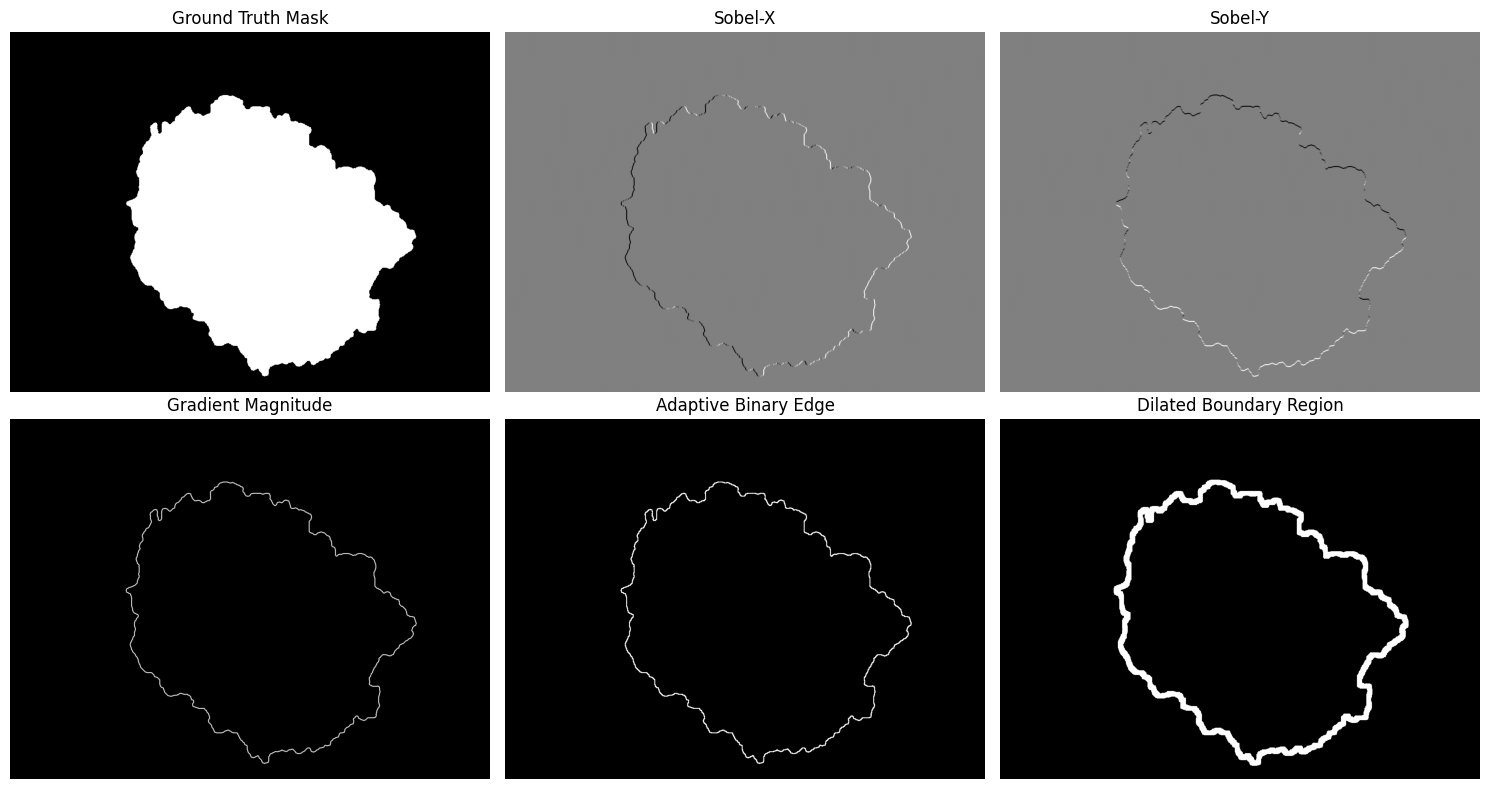

In [18]:
import cv2
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# ----- Load or create a mask (binary numpy image) -----
mask = cv2.imread("/content/drive/MyDrive/BBIoULoss_Updated_V7/BBIoULoss_Updated_V5/kvasir-seg-main/data/Skin_Cancer/Train/masks/ISIC_0000002.jpg", 0) / 255.0   # Load ground truth mask
mask_tensor = torch.tensor(mask).unsqueeze(0).unsqueeze(0).float()  # (1,1,H,W)

# ----- Sobel filters (same as your loss) -----
sobel_x = torch.tensor([[1,0,-1],[2,0,-2],[1,0,-1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
sobel_y = torch.tensor([[1,2,1],[0,0,0],[-1,-2,-1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)

# Apply Sobel
edge_x = F.conv2d(mask_tensor, sobel_x, padding=1)
edge_y = F.conv2d(mask_tensor, sobel_y, padding=1)

# Magnitude
magnitude = torch.sqrt(edge_x**2 + edge_y**2 + 1e-6)

# Adaptive threshold
flat = magnitude.flatten()
percentile = torch.quantile(flat, 0.95)
binary_edge = (magnitude > percentile).float()

# Dilate
kernel_size = 9
dilated = F.max_pool2d(binary_edge, kernel_size, stride=1, padding=kernel_size//2)

# Convert to numpy for plotting
images = [
    mask,
    edge_x[0,0].detach().numpy(),
    edge_y[0,0].detach().numpy(),
    magnitude[0,0].detach().numpy(),
    binary_edge[0,0].detach().numpy(),
    dilated[0,0].detach().numpy(),
]

titles = [
    "Ground Truth Mask",
    "Sobel-X",
    "Sobel-Y",
    "Gradient Magnitude",
    "Adaptive Binary Edge",
    "Dilated Boundary Region",
]

plt.figure(figsize=(15, 8))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')

plt.tight_layout()
plt.savefig("Biou_Sobel_Visualization.png", dpi=300)
plt.show()
